# In-Context Learning

In [ ]:
!pip install -q datasets transformers accelerate bitsandbytes

from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from datasets import load_dataset
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns


# Load Falcon-7B-Instruct
*- Selected because it's open access*

In [ ]:
model_name = "tiiuae/falcon-7b-instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",        # Automatically assigns GPU/CPU
    torch_dtype=torch.float16,
    load_in_4bit=True
)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# Load Finanical PhraseBank

In [ ]:


dataset = load_dataset("financial_phrasebank", "sentences_allagree")
df = pd.DataFrame(dataset['train'])
df = df.rename(columns={"sentence": "text", "label": "true_label"})

label_map = {0: "negative", 1: "neutral", 2: "positive"}
df["label_text"] = df["true_label"].map(label_map)

# Shuffle and sample
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
few_shot = df[:5]
test_set = df[5:25]


# Prompt Builder

In [ ]:
def build_prompt(few_shot_df, test_sentence):
    prompt = "Classify the sentiment of each financial headline as Positive, Neutral, or Negative.\n\n"
    for i, row in few_shot_df.iterrows():
        prompt += f"{i+1}. \"{row['text']}\" → {row['label_text'].capitalize()}\n"
    prompt += f"{len(few_shot_df)+1}. \"{test_sentence}\" →"
    return prompt


# Prediction Loop

In [ ]:
def generate_response(prompt, max_tokens=20):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    output = model.generate(
        **inputs,
        max_new_tokens=max_tokens,
        do_sample=False,
        pad_token_id=tokenizer.eos_token_id
    )
    decoded = tokenizer.decode(output[0], skip_special_tokens=True)
    return decoded[len(prompt):].strip().lower()

predictions = []
for i, row in test_set.iterrows():
    prompt = build_prompt(few_shot, row["text"])
    response = generate_response(prompt)
    for label in ["positive", "neutral", "negative"]:
        if label in response:
            predictions.append(label)
            break
    else:
        predictions.append("unknown")


# Evaluation

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


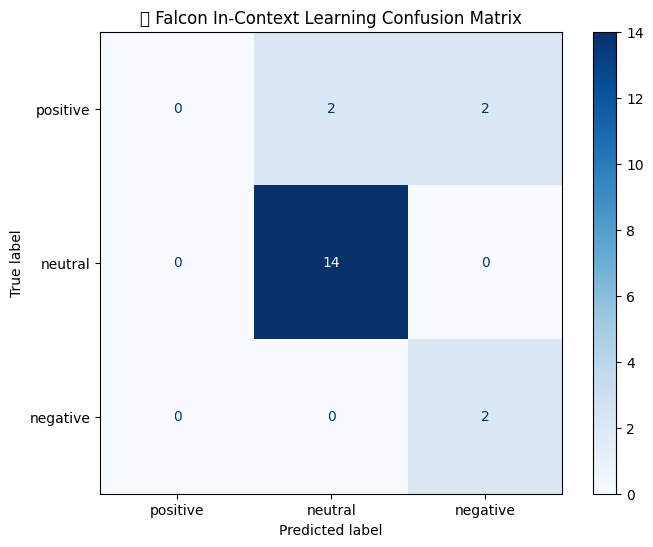

In [ ]:
labels = ["positive", "neutral", "negative"]
cm = confusion_matrix(true, pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap="Blues", ax=ax, colorbar=True)
plt.title("🧠 Falcon In-Context Learning Confusion Matrix")
plt.show()

## Results

# Shot Prompting

Averaged over 5 seeds:
Mean Accuracy: 0.81
Mean Macro F1 Score: 0.77


<ipython-input-17-62de95360b39>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set["predicted_label_9shot"] = preds


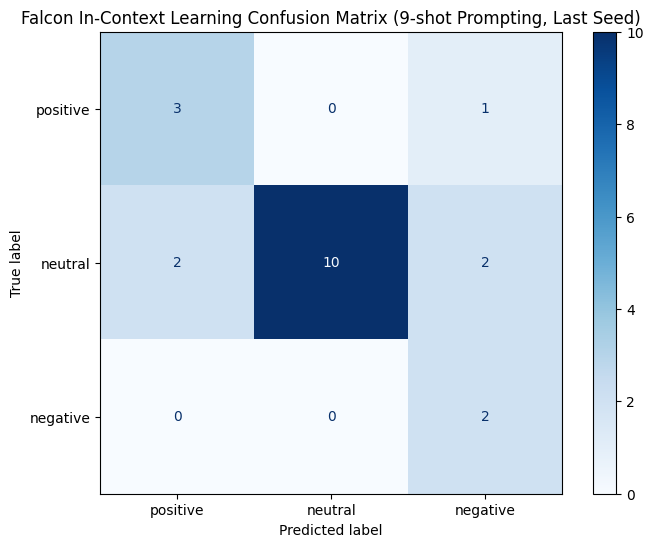

In [ ]:
from sklearn.metrics import f1_score

seeds = [42, 99, 123, 2025, 7]
accuracies = []
f1_macros = []

for seed in seeds:
    few_shot = sample_few_shot_balanced(df, shots_per_class=3, seed=seed)

    preds = []
    for _, row in test_set.iterrows():
        prompt = build_prompt(few_shot, row["text"])
        response = generate_response(prompt)
        for label in ["positive", "neutral", "negative"]:
            if label in response:
                preds.append(label)
                break
        else:
            preds.append("unknown")

    # Save prediction to test set for the *last* seed
    if seed == seeds[-1]:
        test_set["predicted_label_9shot"] = preds

    true = test_set["label_text"]
    pred = preds
    acc = accuracy_score(true, pred)
    f1 = f1_score(true, pred, average="macro", zero_division=0)

    accuracies.append(acc)
    f1_macros.append(f1)

# Display average performance
print(f"Averaged over {len(seeds)} seeds:")
print(f"Mean Accuracy: {np.mean(accuracies):.2f}")
print(f"Mean Macro F1 Score: {np.mean(f1_macros):.2f}")

# Plot confusion matrix from last run
labels = ["positive", "neutral", "negative"]
cm = confusion_matrix(test_set["label_text"], test_set["predicted_label_9shot"], labels=labels)
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay(cm, display_labels=labels).plot(cmap="Blues", ax=ax)
plt.title("Falcon In-Context Learning Confusion Matrix (9-shot Prompting, Last Seed)")
plt.show()



Continuation back in [Main Notebook](../part1_finetuning_Distilbert.ipynb)